In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os

from background_models import phi_g_egb_fermi, phi_e_bg_dampe
from constants import e_low_aniso_fermi, e_high_aniso_fermi, aniso_fermi
from constants import e_low_aniso_ams, e_high_aniso_ams, aniso_ams, rho_max
from constants import dampe_excess_bin_low, dampe_excess_bin_high, dampe_bins
from constants import rho_earth, plot_obs, t_diff, t_loss, fermi_psf
from constants import speed_of_light, kpc_to_cm, dampe_excess_iflux
from constants import fermi_pt_src_sens_0_0, fermi_pt_src_sens_120_45
from finite_clump_vectorized import phi_e, rho_s_dampe, phi_g
from finite_clump_vectorized import line_width_constraint, mass
# from finite_clump_vectorized import differential_aniso, integrated_aniso
from finite_clump_vectorized import rho as density_profile

colors = [c["color"] for c in plt.rcParams['axes.prop_cycle']]
clump_cols = [colors[0]] + colors[2:]

## Profile comparison
Not particularly interesting.

In [2]:
gamma_exp = 0.74
gamma_nfw = 1.0
dist = 5e-2
r_s = np.logspace(-2, 2, 3)

In [3]:
rho_s_exp = rho_s_dampe(dist, r_s, gamma_exp, "exp")
rho_s_nfw = rho_s_dampe(dist, r_s, gamma_nfw, "nfw")

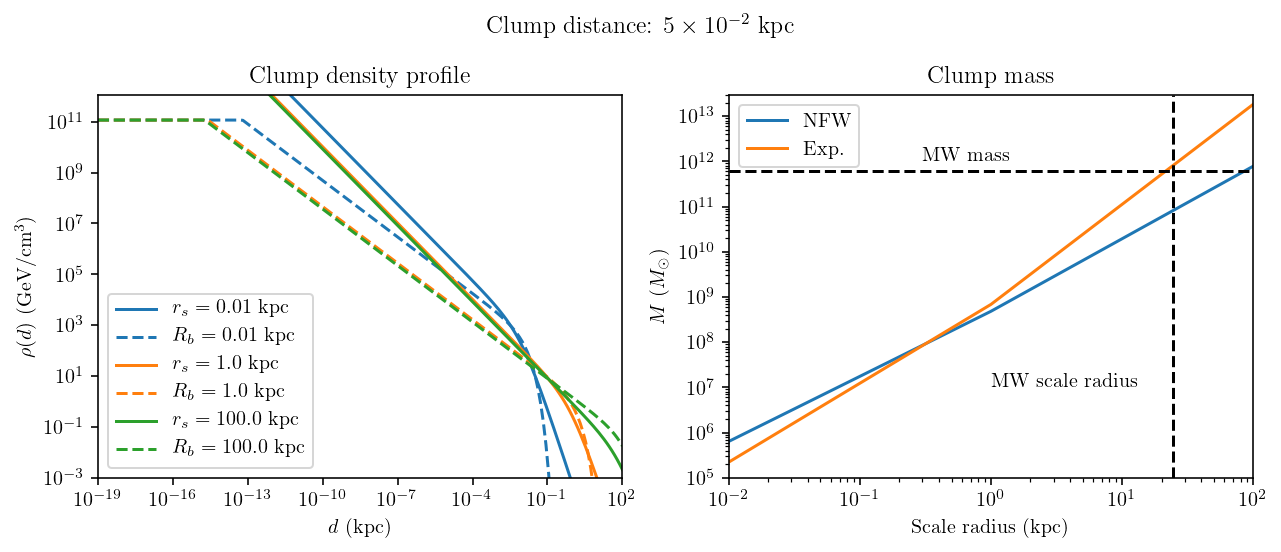

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

ax = axs[0]
rs = np.logspace(-19, 2, 200)
for r, rho_nfw, rho_exp, c in zip(r_s, rho_s_nfw, rho_s_exp, colors):
    ax.plot(rs, density_profile(rs, r, rho_nfw, gamma_nfw, "nfw"),
            color=c, label=r"$r_s = {}$ kpc".format(r))
    ax.plot(rs, density_profile(rs, r, rho_exp, gamma_exp, "exp"),
            '--', color=c, label="$R_b = {}$ kpc".format(r))

# ax.axvline(dist, color='k', linestyle='--', alpha=0.3)
# ax.axvline(1. * np.pi/180 * dist, color='k', linestyle='--')

ax.legend()
ax.set_xlim(rs[[0, -1]])
ax.set_ylim(1e-3, rho_max*10)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$d$ (kpc)")
ax.set_ylabel(r"$\rho(d)$ (GeV/cm$^3$)")
ax.set_title("Clump density profile")

ax = axs[1]
ax.plot(r_s, mass(r_s, rho_s_nfw, gamma_nfw, "nfw"), label="NFW")
ax.plot(r_s, mass(r_s, rho_s_exp, gamma_exp, "exp"), label="Exp.")
# Milky Way mass
ax.axhline(6e11, color='k', linestyle='--')
ax.text(3e-1, 1e12, "MW mass")
# MW scale radius
ax.axvline(24.42, color='k', linestyle='--')
ax.text(1e0, 1e7, "MW scale radius")

ax.legend()
ax.set_xlim(r_s[[0, -1]])
ax.set_ylim(1e5, 3e13)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"Scale radius (kpc)")
ax.set_ylabel(r"$M$ ($M_\odot$)")
ax.set_title("Clump mass")

fig.suptitle(r"Clump distance: $5\times10^{-2}$ kpc")
fig.tight_layout(rect=[0, 0.03, 1, 0.93])

## Making sure stationarity assumption is valid

This shows the clump doesn't travel far relative to its scale radius in a propagation time. The black line is the distance traveled during one propagation time as a function of clump distance. Scale radii in the orange region are smaller than we consider. Clump distances in the blue region are ruled out by line width. The part of the black line that is not excluded by line width is excluded by gamma ray constraints (not shown on this plot).

Text(0,0.5,'$r_{\\mathrm{scale}}$ (kpc)')

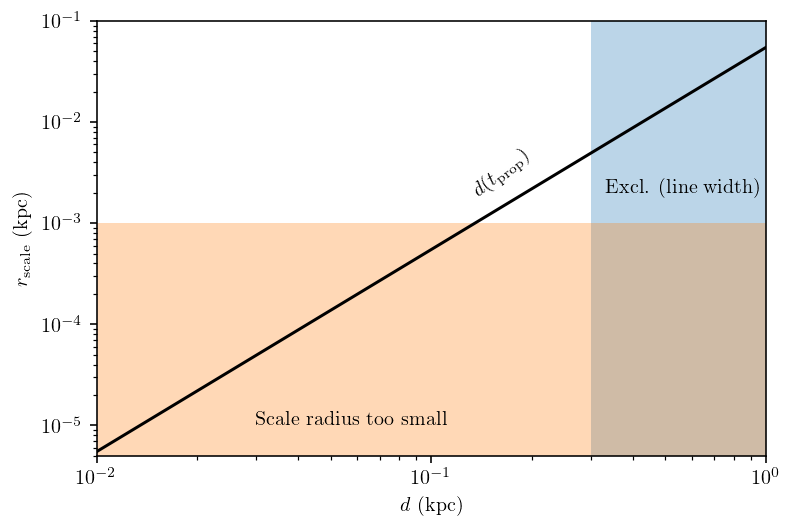

In [5]:
dist = np.logspace(-3, 0, 100)
r_s = np.logspace(-3, 1, 100)
dist_mg, r_s_mg = np.meshgrid(dist, r_s)

t_prop = np.min([t_diff(dampe_excess_bin_high, dist_mg),
                 t_loss(dampe_excess_bin_high) * np.ones_like(dist_mg)],
                axis=0)


# Distance traveled by clump during one propagation time
plt.loglog(dist, 1e-3*speed_of_light/kpc_to_cm*t_prop[-1, :], 'k')
plt.text(1.3e-1, 4e-3, r"$d(t_{\mathrm{prop}})$", rotation=38)

# Shade distances ruled out by line width
plt.fill_betweenx([1e-7, 1e-1], 3e-1, 3e0, alpha=0.3)
plt.text(3.3e-1, 2e-3, "Excl. (line width)")
# Shade scale radii not considered in our work
plt.fill_between([1e-2, 3e0], 1e-7, 1e-3, alpha=0.3)
plt.text(3e-2, 1e-5, "Scale radius too small")

plt.xlim(1e-2, 1e0)
plt.ylim(5e-6, 1e-1)
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$r_{\mathrm{scale}}$ (kpc)")

## Propagation timescales

### Values

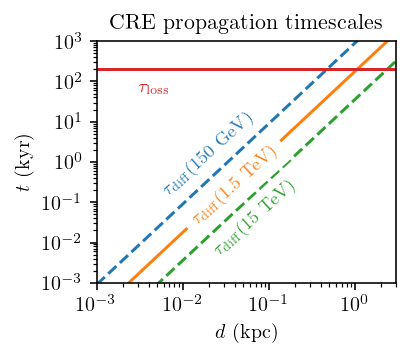

In [6]:
d = np.logspace(-3, np.log10(3e0), 200)
s_to_yr = 1./(365e3 * 24*60*60)

plt.figure(figsize=(3, 2.6))
plt.loglog(d, s_to_yr*t_diff(1.5e2, d), '--', color=colors[0])
plt.text(2e-2, 1.5e0, r"$\tau_{\mathrm{diff}}(150 ~ \mathrm{GeV})$",
         rotation=42, ha="center", va="center", color=colors[0], fontsize=9)

plt.loglog(d, s_to_yr*t_diff(dampe_excess_bin_high, d), color=colors[1])
plt.text(4e-2, 2.6e-1, r"$\tau_{\mathrm{diff}}(1.5 ~ \mathrm{TeV})$",
         rotation=42, ha="center", va="center", color=colors[1], fontsize=9,
         backgroundcolor="w")

plt.loglog(d, s_to_yr*t_diff(1.5e4, d), '--', color=colors[2])
plt.text(7e-2, 4e-2, r"$\tau_{\mathrm{diff}}(15 ~ \mathrm{TeV})$",
         rotation=42, ha="center", va="center", color=colors[2], fontsize=9)

plt.loglog(d, s_to_yr*np.ones_like(d)*t_loss(dampe_excess_bin_high),
           color=colors[3])
plt.text(3e-3, 5e1, r"$\tau_{\rm loss}$", color=colors[3], fontsize=9)

plt.autoscale(axis="x", tight=True)
plt.ylim(1e-3, 1e3)
plt.title("CRE propagation timescales", fontsize=11)
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$t$ (kyr)")
# plt.legend()

plt.tight_layout()
plt.savefig("figures/propagation_timescales.pdf")

## $e^\pm$ anisotropy

In [2]:
gamma_exp = 0.74
r_s = np.array([1e-3, 2e-2, 5e-1, 2e0])
dist = 2e-1
e_epm = np.logspace(2, np.log10(2e3), 300)

In [3]:
rho_s_exp = rho_s_dampe(dist, r_s, gamma_exp, "exp")

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


In [5]:
# Integrated anisotropy
int_aniso = {r: [] for r in r_s}

for r, rho in zip(r_s, rho_s_exp):
    for low, high in zip(e_low_aniso_fermi, e_high_aniso_fermi):
        int_aniso[r].append(integrated_aniso(dist, r, rho, gamma_exp, "exp",
                                             low, high))

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dphi3_de_dr_dd_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dphi3_de_dr_dd_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dphi3_de_dr_dd_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dphi3_de_dr_dd_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dphi3_de_dr_dd_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dph

In [4]:
# Determine whether the clump is excluded by line width
lw_excess = []

for r, rho in zip(r_s, rho_s_exp):
    lw_excess.append(line_width_constraint(dist, r, rho, gamma_exp, "exp"))
    
lw_excess = np.array(lw_excess)

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


KeyboardInterrupt: 

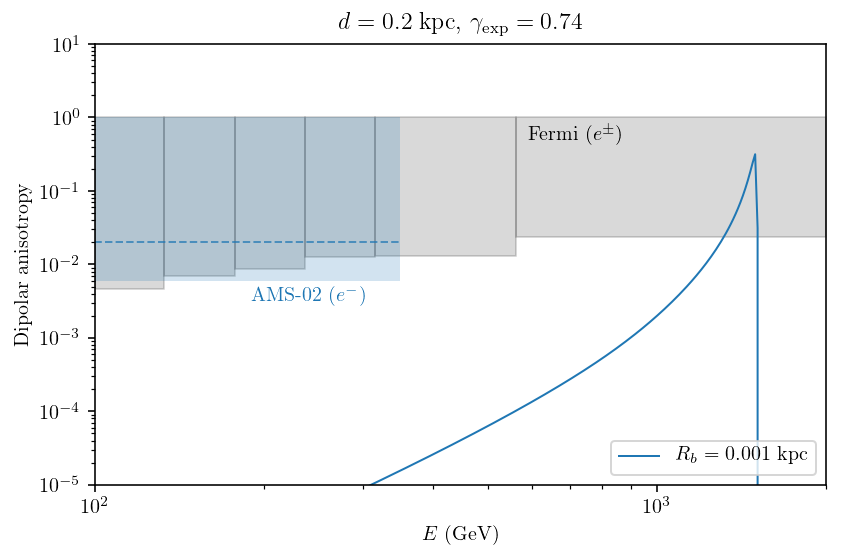

In [10]:
# plt.figure(figsize=(5, 3.5))
plt.xscale('log')
plt.yscale('log')

# Fermi CRE bounds
for i, (low, high, aniso_ul) in enumerate(zip(e_low_aniso_fermi,
                                              e_high_aniso_fermi,
                                              aniso_fermi)):
    plt.fill_between([low, high], 2*[aniso_ul], 2*[1], color='k', alpha=0.15, linewidth=1)
plt.text(5.9e2, 5.1e-1, r"Fermi ($e^\pm$)")

# AMS-02 bounds
plt.fill_between([e_low_aniso_ams, e_high_aniso_ams], 2*[aniso_ams], 2*[1],
                 alpha=0.2, linewidth=1)
plt.plot([e_low_aniso_ams, e_high_aniso_ams], 2*[0.020],
         color=colors[0], linewidth=1, alpha=0.7, linestyle='--')
plt.text(1.9e2, 3.25e-3, r"AMS-02 ($e^-$)", color=colors[0])

# Clump anisotropy
for r, rho, lw_ex, c in zip(r_s, rho_s_exp, lw_excess, clump_cols):
    # "Differential" anisotropy
    if int(r) == r:
        label = r"$R_b = {}$ kpc".format(int(r))
    else:
        label = r"$R_b = {}$ kpc".format(r)
#     if lw_ex > 3.:
#         linestyle = ":"
#     else:
#         linestyle = "-"
    linestyle = "-"
    plt.plot(e_epm, differential_aniso(e_epm, dist, r, rho, gamma_exp, "exp"),
             color=c, label=label, linestyle=linestyle, linewidth=1)

    # "Integral" anisotropy
    for low, high, aniso in zip(e_low_aniso_fermi,
                                e_high_aniso_fermi,
                                int_aniso[r]):
        plt.plot([low, high], 2*[aniso], color=c, linestyle=linestyle,
                 linewidth=1)

# Point-like source
# plt.plot(e_epm[:len(aniso_ptlike)], anisotropy_pt(e_epm[:len(aniso_ptlike)]), '--k')

plt.xlim(100, 2e3)
plt.ylim(1e-5, 1e1)
plt.legend(loc="lower right")
plt.xlabel(r"$E$ (GeV)")
plt.ylabel("Dipolar anisotropy")
plt.title(r"$d = 0.2$ kpc, $\gamma_{\rm exp} = %.2f$" % gamma_exp)
plt.tight_layout()

# plt.savefig("figures/anisotropy_new.pdf")

* I don't understand why the integrated anisotropies are greater than 1
* Why are my anisotropies larger than in the point-source case? Why is the point-source anisotropy also larger than 1???

In [8]:
from constants import D, lambda_prop, speed_of_light, kpc_to_cm

r_pt = 1e-5
rho_pt = rho_s_dampe(dist, r_pt, gamma_exp, "exp")

def differential_aniso_pt(e):
    def _helper(e):
        if e < dampe_excess_bin_high:
            phi_clump = phi_e(e, dist, r_pt, rho_pt, gamma_exp, "exp")
            coeff = 3*kpc_to_cm*D(e)/speed_of_light * 2*dist/lambda_prop(e, dampe_excess_bin_high)
            
            return coeff * phi_clump / (bg_dampe(e) + phi_clump)
        else:
            return 0.
    return np.vectorize(_helper)(e)


def integrated_aniso_pt(e_low, e_high):
    def integrand_num(e):
        if e < dampe_excess_bin_high:
            phi_clump = phi_e(e, dist, r_pt, rho_pt, gamma_exp, "exp")
            coeff = 3*kpc_to_cm*D(e)/speed_of_light * 2*dist/lambda_prop(e, dampe_excess_bin_high)
            return phi_clump * coeff
        else:
            return 0.

    def integrand_denom(e):
        phi_clump = phi_e(e, dist, r_pt, rho_pt, gamma_exp, "exp")
        return phi_clump + bg_dampe(e)
    
    int_num = quad(integrand_num, e_low, e_high, epsabs=0, epsrel=1e-5)[0]
    int_denom = quad(integrand_denom, e_low, e_high, epsabs=0, epsrel=1e-5)[0]
    print(int_num, int_denom)
    
    return int_num / int_denom

In [69]:
integrated_aniso_pt(low, high)

(2.60814692339628e-10, 1.8211270390580792e-08)


0.014321608912826104

In [51]:
3*kpc_to_cm*D(1400)/speed_of_light * 2*dist/lambda_prop(1400, dampe_excess_bin_high)

anisotropy_pt(1480)

(2.623532476464975e-12, array(1.74597513e-12), 0.399581666566038)
(2.623532476464975e-12, array(1.74597513e-12), 0.399581666566038)


array(0.32628043)

In [56]:
from scipy.integrate import quad

low, high = e_low_aniso_fermi[-1], e_high_aniso_fermi[-1]
# clump
print(quad(lambda e: differential_aniso(e, dist, r_s[-1], rho_s_exp[-1], gamma_exp, "exp"),
           low, high, epsabs=0, epsrel=1e-5) / (high - low))
# pt
print(quad(anisotropy_pt, low, high, epsabs=0, epsrel=1e-5) / (high - low))

[2.45472235e-02 2.41669007e-07]
[3.43136281e-02 1.76438525e-08]


#### Sanity checks

In [4]:
from constants import D, lambda_prop, speed_of_light, kpc_to_cm

aniso_ptlike = []

for e in e_epm:
    if e >= dampe_excess_bin_high:
        break
    else:
        aniso_ptlike.append(3*kpc_to_cm*D(e) / speed_of_light * 2 * dist / lambda_prop(e, dampe_excess_bin_high) *
                            phi_e(e, dist, r_s[0], rho_s_exp[0], gamma_exp, "exp") / bg_dampe(e))


plt.plot(e_epm[:len(aniso_ptlike)], aniso_ptlike, '--k')

NameError: name 'e_epm' is not defined

In [29]:
from finite_clump_vectorized import anisotropy_constraint
from scipy.integrate import quad

In [30]:
# Integrated anisotropy
clump_aniso = {r: [] for r in r_s}

for r, rho in zip(r_s, rho_s_exp):
    print("r:", r)
    print("true iflux:", quad(lambda e: 2*phi_e(e, dist, r, rho, gamma_exp, "exp"),
                              e_low_aniso_fermi[-1], e_high_aniso_fermi[-1],
                              epsabs=0, epsrel=1e-5)[0])
    anisotropy_constraint(dist, r, rho, gamma_exp, "exp", debug=True)
    print("------")

('r:', 0.001)
('true iflux:', 4.671282471471589e-10)
('>>> ifluxes:', 4.67128247120083e-10, 6.439952622224211e-184)
('>>> total iflux:', 4.67128247120083e-10)
('>>> bg iflux:', 1.7977707579619047e-08)
('>>> anisotropy:', 0.025325692866449697)

('>>> ifluxes:', 4.67128247120083e-10, 6.439952622224211e-184)
('>>> total iflux:', 4.67128247120083e-10)
('>>> bg iflux:', 1.7977707579619047e-08)
('>>> anisotropy:', 0.025325692866449697)

------
('r:', 0.02)
('true iflux:', 4.670959388784611e-10)
('>>> ifluxes:', 4.670959380742014e-10, 5.99163374086894e-19)
('>>> total iflux:', 4.670959386733648e-10)
('>>> bg iflux:', 1.7977707579619047e-08)
('>>> anisotropy:', 0.025323985534017816)

('>>> ifluxes:', 4.670959380742014e-10, 5.99163374086894e-19)
('>>> total iflux:', 4.670959386733648e-10)
('>>> bg iflux:', 1.7977707579619047e-08)
('>>> anisotropy:', 0.025323985534017816)

------
('r:', 0.5)
('true iflux:', 5.268872702420453e-10)
('>>> ifluxes:', 4.445923832264328e-10, 8.229321575003304e-11)
('>

## $e^\pm$ spectra and density profiles

Compute clump normalizations and spectra

In [7]:
gamma_exp = 0.74
r_s = np.array([1e-3, 2e-2, 5e-1, 2e0])
dist = 2e-1

In [8]:
rho_s_exp = rho_s_dampe(dist, r_s, gamma_exp, "exp")

In [9]:
# Determine whether the clump is excluded by line width
lw_excess = []

for r, rho in zip(r_s, rho_s_exp):
    lw_excess.append(line_width_constraint(dist, r, rho, gamma_exp, "exp"))
    
lw_excess = np.array(lw_excess)

In [10]:
e_epm = np.linspace(500, 2000, 500)

phi_e_exp = []
for r, rho in zip(r_s, rho_s_exp):
    phi_e_exp.append(
        phi_e(e_epm, dist, r, rho, gamma_exp, "exp"))
phi_e_exp = np.array(phi_e_exp)

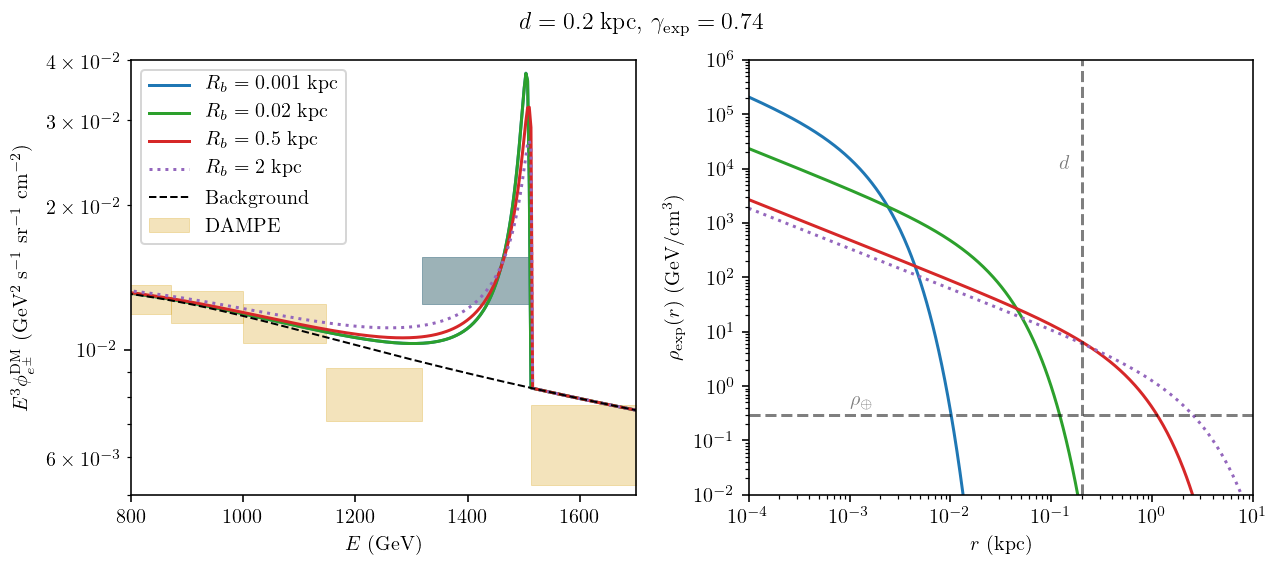

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# e+/e- fluxes
ax = axs[0]
# DAMPE observations
power = 3
plot_obs(power, ax, True)
# DM
for phi, r, lw_ex, c in zip(phi_e_exp, r_s, lw_excess, clump_cols):
    if lw_ex > 3.:
        linestyle = ":"
    else:
        linestyle = "-"

    if int(r) == r:
        label = r"$R_b = {}$ kpc".format(int(r))
    else:
        label = r"$R_b = {}$ kpc".format(r)
    
    # Factor of two since we want the e+- spectrum
    ax.plot(e_epm, e_epm**power * (2*phi + phi_e_bg_dampe(e_epm)),
            color=c, linestyle=linestyle, label=label)
    
# Background only
ax.plot(e_epm, e_epm**3 * phi_e_bg_dampe(e_epm), "--k",
        linewidth=1, label="Background")
# Formatting
ax.set_yscale('log')
ax.set_xlim(8e2, 1.7e3)
# ax.set_ylim(1e-12, 1e-10)  # power=0
# ax.set_ylim(2e-6, 4e-5)  # power=2
ax.set_ylim(5e-3, 4e-2)  # power=3
ax.legend()
ax.set_xlabel(r"$E$ (GeV)")
ax.set_ylabel(r"$E^3 \phi_{e^\pm}^{\rm DM}$ (GeV$^2$ s$^{-1}$ sr$^{-1}$ cm$^{-2}$)")

# Halo profiles
ax = axs[1]
rs = np.logspace(-4, 1, 500)
for r, rho, lw_ex, c in zip(r_s, rho_s_exp, lw_excess, clump_cols):
    if lw_ex > 3.:
        linestyle = ":"
    else:
        linestyle = "-"
    ax.loglog(rs, density_profile(rs, r, rho, gamma_exp, "exp"),
              color=c, linestyle=linestyle)
    
    rho_cl = density_profile(dist, r, rho, gamma_exp, "exp")

ax.axvline(dist, color="k", linestyle="--", alpha=0.5)
ax.text(1.2e-1, 1e4, r"$d$", alpha=0.5)
ax.axhline(rho_earth, color="k", linestyle="--", alpha=0.5)
ax.text(1e-3, 4e-1, r"$\rho_\oplus$", alpha=0.5)
ax.set_xlim(rs[[0, -1]])
ax.set_ylim(1e-2, 1e6)
ax.set_xlabel(r"$r$ (kpc)")
ax.set_ylabel(r"$\rho_{\rm exp}(r)$ (GeV/cm$^3$)")

fig.suptitle(r"$d = 0.2$ kpc, $\gamma_{\rm exp} = %.2f$" % gamma_exp)
fig.tight_layout()
fig.subplots_adjust(top=0.90)

fig.savefig("figures/epm_spectra_clump_profiles_exp.pdf")

## $\gamma$-ray spectra

Fermi broadband flux sensitivity: max flux of a power law source at the detection threshold for any power law. From [here](http://www.slac.stanford.edu/exp/glast/groups/canda/lat_Performance.htm).

### Figure for section 4

In [16]:
gamma_exp = 0.74
r_s = np.array([1e-3, 2e-2, 5e-1, 2e0])
dist = 2e-1

th_maxes = np.array([fermi_psf, 1 * np.pi / 180])

In [17]:
rho_s_exp = rho_s_dampe(dist, r_s, gamma_exp, "exp")

In [18]:
# Determine whether the clump is excluded by line width
lw_excess = []

for r, rho in zip(r_s, rho_s_exp):
    lw_excess.append(line_width_constraint(dist, r, rho, gamma_exp, "exp"))
    
lw_excess = np.array(lw_excess)

In [19]:
e_g = np.linspace(30, 2000, 500)

phi_g_exp = {th: [] for th in th_maxes}
for th in th_maxes:
    for r, rho in zip(r_s, rho_s_exp):
        phi_g_exp[th].append(
            phi_g(e_g, dist, r, rho, gamma_exp, "exp", th_max=th))
    phi_g_exp[th] = np.array(phi_g_exp[th])

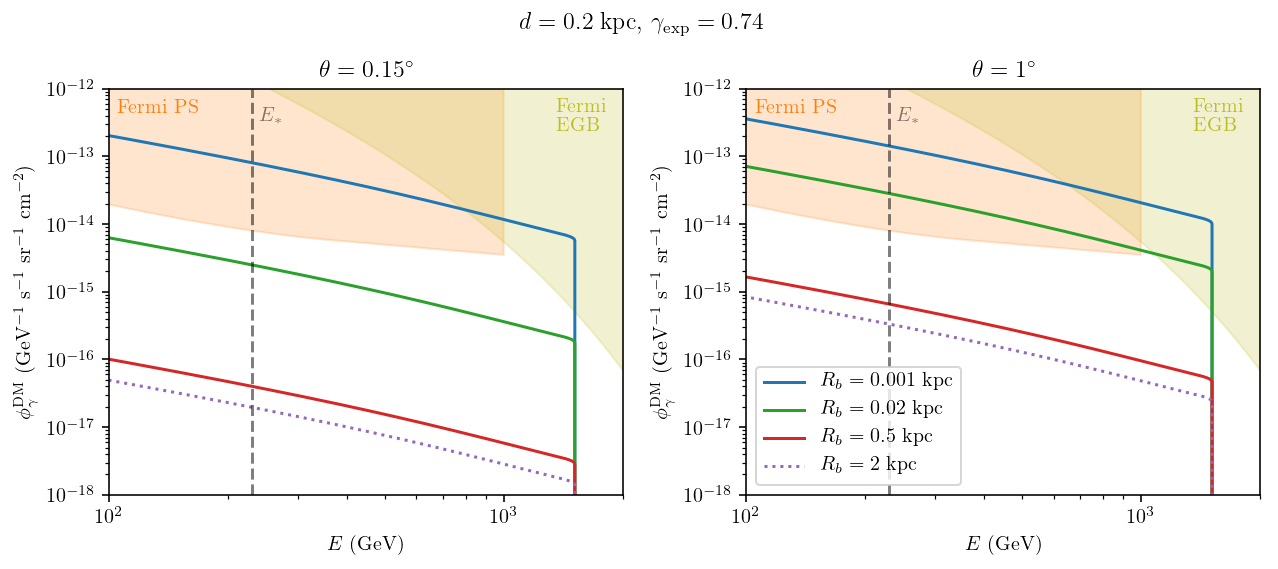

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
power = 0

for th, ax in zip(th_maxes, axs):
    # DM
    for phi, r, lw_ex, c in zip(phi_g_exp[th], r_s, lw_excess, clump_cols):
        if lw_ex > 3.:
            linestyle = ":"
        else:
            linestyle = "-"
        if int(r) == r:
            label = r"$R_b = {}$ kpc".format(int(r))
        else:
            label = r"$R_b = {}$ kpc".format(r)
        ax.plot(e_g, e_g**power * phi,
                color=c, linestyle=linestyle, label=label)
    
    # Fermi
    ax.fill_between(e_g, e_g**power * fermi_pt_src_sens_120_45(e_g), np.ones_like(e_g),
                    color=colors[1], alpha=0.2, linewidth=1)
#     ax.loglog(e_g, e_g**power * fermi_pt_src_sens_0_0(e_g), '--', color=colors[1],
#               alpha=0.7, linewidth=1)
    ax.fill_between(e_g, e_g**power * phi_g_egb_fermi(e_g), np.ones_like(e_g),
                    color=colors[8], alpha=0.2, linewidth=1)
    
    # Formatting
    ax.axvline(230, color='k', linestyle='--', alpha=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(100, 2e3)
    ax.set_ylim(1e-18, 1e-12)
    ax.set_xlabel(r"$E$ (GeV)")
    ax.set_ylabel(r"$\phi_{\gamma}^{\rm DM}$ (GeV$^{-1}$ s$^{-1}$ sr$^{-1}$ cm$^{-2}$)")
    ax.text(1.05e2, 4.5e-13, "Fermi PS", color=colors[1])
    ax.text(1350, 2.3e-13, "Fermi\nEGB", color=colors[8])
    ax.text(240, 3e-13, r"$E_*$", alpha=0.5)

# axs[0].legend(loc="center left")
axs[1].legend()#loc="lower left")
axs[0].set_title(r"$\theta = 0.15^\circ$")
axs[1].set_title(r"$\theta = 1^\circ$")

fig.suptitle(r"$d = 0.2$ kpc, $\gamma_{\rm exp} = %.2f$" % gamma_exp)
fig.tight_layout()
fig.subplots_adjust(top=0.85)

fig.savefig("figures/gamma_spectra_constraints_exp.pdf")

#### Checking galactic background

In [10]:
e_fgdil, flux_fgdil = np.loadtxt("data/fermi/galactic_diffuse_intermediate_latitudes.csv").T
e_fgdil /= 1e3
flux_fgdil /= 1e3
flux_fgdil /= e_fgdil**2

In [16]:
1e-3/1e6**2 * 1e3

1e-12

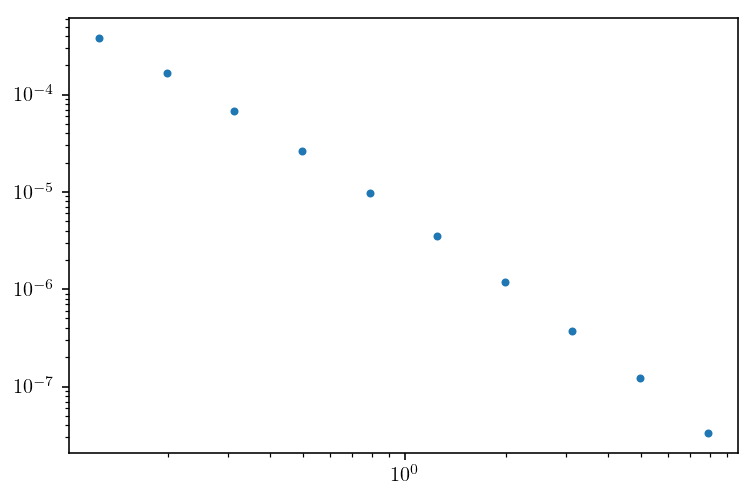

In [12]:
plt.loglog(e_fgdil, e_fgdil**power * flux_fgdil, '.')

### GC flux from DM

Flux from DM annihilating in the GC. This is quite subdominant to the flux from the clump.

In [3]:
rho_s_mw = 0.184
r_s_mw = 24.42
gamma_mw = 1.

phi_g(1.5e3, 8.5, r_s_mw, rho_s_mw, gamma_mw, "nfw", th_max=fermi_psf)

array(3.86814929e-18)

# Scratch

In [162]:
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

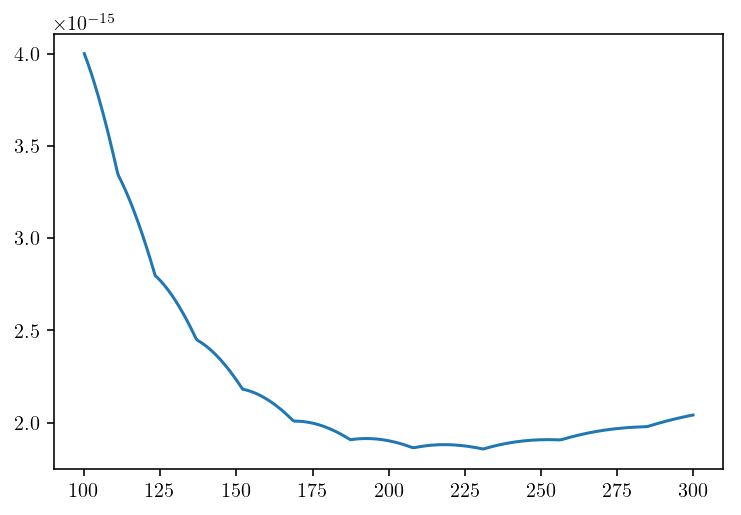

In [173]:
plt.plot(e_g, fermi_sensitivity_interp(e_g) - phi)

In [169]:
dm_g_interp = interp1d(e_g, phi)
fermi_sensitivity_interp = interp1d(e_g_f, phi_g_f, bounds_error=False)

In [168]:
minimize_scalar(lambda e: fermi_sensitivity_interp(e) - dm_g_interp(e), bracket=(100, 200, 299))

     fun: 1.8561561777316065e-15
    nfev: 33
     nit: 29
 success: True
       x: 231.00999984255506

(1e-15, 3e-15)

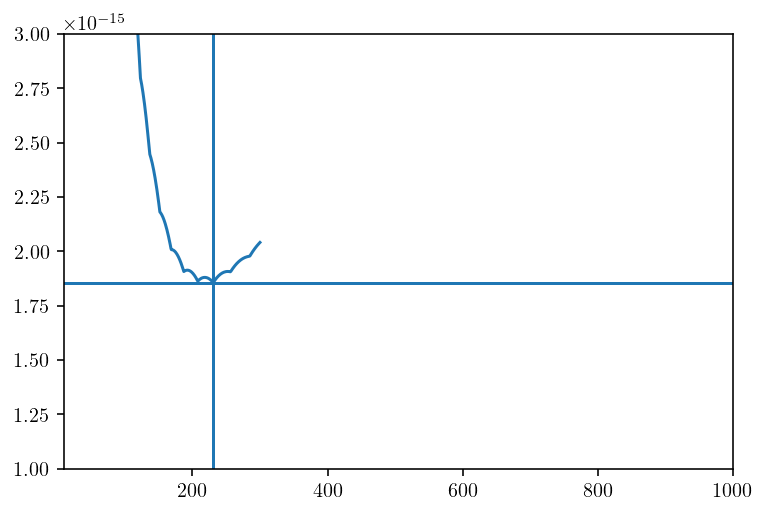

In [174]:
plt.plot(e_g, fermi_sensitivity_interp(e_g) - phi)
plt.axvline(230)
plt.axhline(1.8558198565093894e-15)
# plt.plot(e_g_f, phi_g_f, '--k')
plt.xlim(1e1, 1e3)
plt.ylim(1e-15, 3e-15)

How to set a point source constraint with Fermi:
1. Find $E_*$, the energy where the gamma-ray spectrum first touches Fermi's sensitivity curve. Since the DM mass is held fixed at ~1.5 TeV and the spectrum is always the AP one, this is fixed in our analysis. Turns out $E_* \approx 230$ GeV.
2. Get $\phi_\gamma^{\rm DM}(E_*)$ for the clump with $\rho_s = 1$ by integrating over the angular region for a point source.
3. Since $\phi_\gamma^{\rm DM}(E_*) \propto \rho_s^2$, under the assumption the clump was not detected the Fermi constraint on $\rho_s$ is

$$\rho_s \leq \sqrt{\phi_\gamma^{\rm Fermi} / \phi_\gamma^{\rm DM}}.$$

In [113]:
1e-2/2.5e-3

4.0